# Convolutional Neural Network

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.5
Scikit-Learn 1.0.2
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import os

##  VGG16

In [3]:
import tensorflow.keras as keras

vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [4]:
import matplotlib.pyplot as plt
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    path_dir = '../dataset_mel_final/train'
    parth_dir_test = '../dataset_mel_final/test'

    datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.2)

    train_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(150,150),
        shuffle=True,
        subset='training',
        batch_size = 64,
        class_mode = 'binary'
    )
    
    val_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(150,150),
        subset='validation',
        batch_size = 64,
        class_mode = 'binary'
    )

    test_dataset = datagen.flow_from_directory(parth_dir_test,
                                        target_size= (150,150),
                                        batch_size = 64,
                                        class_mode = 'binary')
    return train_dataset, val_dataset, test_dataset

In [6]:
train_dataset, val_dataset, test_dataset = generators((150,150), preprocessing=vgg16.preprocess_input)

Found 1102 images belonging to 2 classes.
Found 274 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


In [7]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [8]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)

# final softmax layer
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
for layer in conv_model.layers:
    layer.trainable = False

In [10]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime

#rm -rf /logs/

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_vgg16.h5', monitor='val_loss', mode='min', save_best_only=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20)

# Create a TensorBoard callback
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    callbacks = [tensorboard_callback,es,mc,reduceLR],
    epochs=35
)

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
18/18 [==============================] - 19s 525ms/step - loss: 0.6717 - acc: 0.6098 - val_loss: 0.5904 - val_acc: 0.8504
Epoch 2/35
18/18 [==============================] - 5s 246ms/step - loss: 0.5661 - acc: 0.7722 - val_loss: 0.4948 - val_acc: 0.8504
Epoch 3/35
18/18 [==============================] - 4s 247ms/step - loss: 0.4755 - acc: 0.8230 - val_loss: 0.3996 - val_acc: 0.8869
Epoch 4/35
18/18 [==============================] - 4s 229ms/step - loss: 0.4128 - acc: 0.8466 - val_loss: 0.3416 - val_acc: 0.9015
Epoch 5/35
18/18 [==============================] - 4s 241ms/step - loss: 0.3803 - acc: 0.8539 - val_loss: 0.3000 - val_acc: 0.9124
Epoch 6/35
18/18 [==============================] - 4s 223ms/step - loss: 0.3385 - acc: 0.8711 - val_loss: 0.2748 - val_acc: 0.9088
Epoch 7/35
18/18 [==============================] - 4s 220ms/step - loss: 0.3046 - acc: 0.8911 - val_loss: 0.2408 - val_acc: 0.9307
Epoch 8/35
18/18 [==============================] - 4s 222ms/step - loss: 0

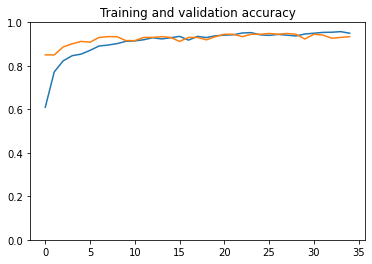

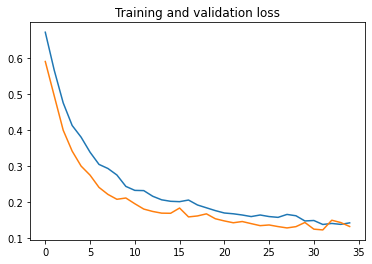

In [14]:
plot_history(history, yrange=(0,1))

In [15]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16560), started 1:17:48 ago. (Use '!kill 16560' to kill it.)

In [16]:
full_model.load_weights('best_vgg16.h5')

In [17]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
score = full_model.evaluate(test_dataset, verbose=0)

print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 0.27585816383361816
Test accuracy 0.9040697813034058


In [19]:
#Overfitting -> Your training accuracy will be higher than the accuracy on the validation/test set

#Overfitting indicates that your model is too complex for the problem that it is solving,
#filters in the case of Convolutional Neural Networks, and layers in the case of overall Deep Learning Models

#How do you know if your model is underfitting? Your model is underfitting if the accuracy on the validation set 
#is higher than the accuracy on the training set. Additionally, 
#if the whole model performs bad this is also called underfitting.

#https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d